# 📘 Forecast-based Wind Power Prediction Demo (DK1)

This notebook uses future wind speed forecasts to estimate wind power output using a trained XGBoost model

In [1]:
# 1. Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

2025-04-07 20:31:18.834883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


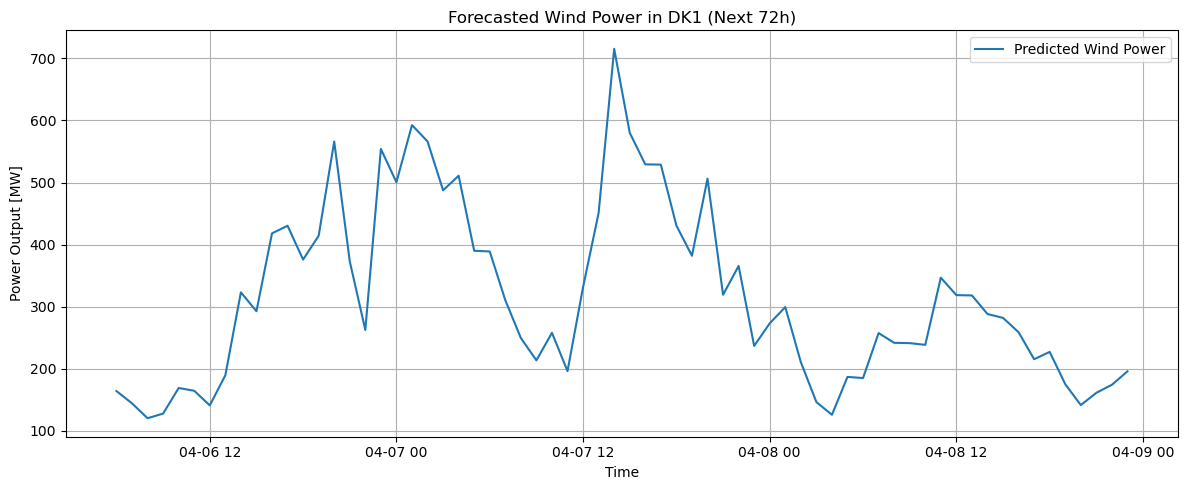

In [2]:
# Forecast using xgboost

# 1. Load forecast data
df = pd.read_csv("../data/forecast_wind_dk1.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 2. Feature engineering (match training features)
df["lag1"] = df["windspeed_10m"].shift(1)
df["lag3"] = df["windspeed_10m"].shift(3)
df["lag6"] = df["windspeed_10m"].shift(6)
df["rolling_mean_3"] = df["windspeed_10m"].rolling(3).mean()
df["delta_wind"] = df["windspeed_10m"] - df["lag1"]
df["windspeed_cubed"] = df["windspeed_10m"] ** 3

df["hour"] = df["timestamp"].dt.hour
df["month"] = df["timestamp"].dt.month
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df["season"] = df["month"].map({
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "fall", 10: "fall", 11: "fall"
})
df = pd.get_dummies(df, columns=["season"])

# Ensure all season columns exist
for col in ["season_fall", "season_spring", "season_summer", "season_winter"]:
    if col not in df.columns:
        df[col] = 0

# Define features used in training
features_v4 = [
    'windspeed_10m', 'windspeed_cubed', 'lag1', 'lag3', 'lag6',
    'rolling_mean_3', 'delta_wind',
    'winddirection_10m', 'temperature_2m', 'surface_pressure', 'relativehumidity_2m',
    'hour', 'month', 'dayofweek', 'is_weekend',
    'season_fall', 'season_spring', 'season_summer', 'season_winter'
]

# Drop rows with NA from shifting and rolling
df.dropna(inplace=True)
X_forecast = df[features_v4]

# 3. Load trained model
model = joblib.load("../models/xgboost_model.pkl")  # Version 4 model

# 4. Make predictions
df["wind_power_predicted"] = model.predict(X_forecast)

# 5. Save the forecast results
#os.makedirs("../data", exist_ok=True)
df.to_csv("../data/xgboost_forecast_power_dk1.csv", index=False)

# 6. Plot the forecasted wind power
plt.figure(figsize=(12,5))
plt.plot(df["timestamp"], df["wind_power_predicted"], label="Predicted Wind Power")
plt.title("Forecasted Wind Power in DK1 (Next 72h)")
plt.xlabel("Time")
plt.ylabel("Power Output [MW]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/xgboost_forecasted_wind_power.png", dpi=500)
plt.show()

In [ ]:
# Forecast using LSTM

# 1. Load forecast wind speed
df = pd.read_csv("data/forecast_wind_dk1.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 2. Add dummy column to match training format
df["wind_power_actual"] = 0.0

# 3. Normalize using previously saved scaler
scaler = joblib.load("models/scaler_lstm_onlywind.pkl")
data_scaled = scaler.transform(df[["wind_power_actual", "windspeed_10m"]])

# 4. Create sequences (same logic as training)

lookback = 24
def create_sequences(data, lookback):
    X = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :])
    return np.array(X)

X_forecast = create_sequences(data_scaled, lookback)

# 5. Load trained LSTM model

model = load_model("models/lstm_model.keras")

# 6. Predict
y_pred = model.predict(X_forecast)

# 7. Inverse transform
dummy = np.zeros((len(y_pred), data_scaled.shape[1]))
dummy[:, 0] = y_pred[:, 0]
y_pred_inv = scaler.inverse_transform(dummy)[:, 0]

# 8. Create result DataFrame
df_result = df.copy().iloc[lookback:].reset_index(drop=True)
df_result["wind_power_predicted_lstm"] = y_pred_inv

# 9. Save result
df_result.to_csv("data/lstm_forecast_power_dk1.csv", index=False)

# 10. Plot

os.makedirs("../plots", exist_ok=True)

plt.figure(figsize=(12,5))
plt.plot(df_result["timestamp"], df_result["wind_power_predicted_lstm"], label="LSTM Predicted Wind Power")
plt.title("LSTM Forecasted Wind Power in DK1 (Next 72h)")
plt.xlabel("Time")
plt.ylabel("Power Output [MW]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/lstm_forecasted_wind_power.png")
plt.show()
